### Import libraries

In [3]:
# Import all libraries regarding torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde, lognorm
import os
from torch.utils.data import Dataset, DataLoader
import time
import shutil
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets

### Read Input data

In [4]:
# Reading from RSA_input.csv
df = pd.read_csv('RSA_input.csv') # add csv file to the correct location
grain_R = df["grain_R"]
grain_asp = df["grain_asp"]

# Combined into numpy shape (30218, 2)
grainsData = np.column_stack((grain_R, grain_asp))
print(f"grainsData shape: {grainsData.shape}")

exp_max_R = np.max(grainsData[:,0])
exp_min_R = np.min(grainsData[:,0])
exp_max_asp = np.max(grainsData[:,1])
exp_min_asp = np.min(grainsData[:,1])

print("[min, max] of exp_grain_R: [{}, {}]".format(exp_min_R, exp_max_R))
print("[min, max] of exp_grain_asp: [{}, {}]".format(exp_min_asp, exp_max_asp))

device = "cuda:0" if torch.cuda.is_available() else "cpu"

grainsData shape: (30218, 2)
[min, max] of exp_grain_R: [3.989422804, 108.8169461]
[min, max] of exp_grain_asp: [1.0, 6.209501941]


### Generator and Discriminator definition

In [5]:
# Generator

class Generator(nn.Module):
    def __init__(self, latent_Gaussian_dimension, number_of_grain_features):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # change width and depth of the network here

            nn.Linear(latent_Gaussian_dimension, 120),
            #nn.LayerNorm(80),
            nn.ReLU(True),

            nn.Linear(120, 80),
            #nn.LayerNorm(80),
            nn.ReLU(True),

            nn.Linear(80, 40),
            #nn.LayerNorm(40),
            nn.ReLU(True),

            nn.Linear(40, number_of_grain_features),
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, number_of_grain_features):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # change width and depth of the network here
            nn.Linear(number_of_grain_features, 40),
            #nn.LayerNorm(40),
            nn.ReLU(True),

            nn.Linear(40, 80),
            #nn.LayerNorm(80),
            nn.ReLU(True),

            nn.Linear(80, 120),
            #nn.LayerNorm(120),
            nn.ReLU(True),

            nn.Linear(120, 160),
            nn.ReLU(True),

            nn.Linear(160, 1),
            #nn.Sigmoid()
            # The output of discriminator is no longer a probability,
            # we do not apply sigmoid at the output of discriminator.
        )

    def forward(self, x):
        return self.model(x)

### Plotting generated data

In [6]:
def plot_data(epoch, grains):
    # Plot 2 subfigures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    fontsize = 10
    df = pd.read_csv('RSA_input.csv')
    exp_grain_R = df["grain_R"]
    exp_grain_asp = df["grain_asp"]

    generated_data = pd.read_csv(f'downsampled_grains_WGAN_CP/epoch_{epoch}/grains_{grains}.csv')
    generated_grain_R = generated_data["grain_R"]
    generated_grain_asp = generated_data["grain_asp"]

    # Plot scatterplot
    ax1.scatter(exp_grain_R, exp_grain_asp, alpha=0.5)
    ax1.set_title(f'Epoch {epoch}: Experimental \ngrain_R and grain_asp', fontsize=fontsize)
    ax1.set_xlabel('grain_R', fontsize=fontsize)
    ax1.set_ylabel('grain_asp', fontsize=fontsize)
    ax1.set_xlim([0, 100])
    ax1.set_ylim([0.5, 7])

    # Plot scatterplot
    ax2.scatter(generated_grain_R, generated_grain_asp, alpha=0.5)
    ax2.set_title(f'Epoch {epoch}: WGAN CP \ngrain_R and grain_asp', fontsize=fontsize)
    ax2.set_xlabel('grain_R', fontsize=fontsize)
    ax2.set_ylabel('grain_asp', fontsize=fontsize)
    ax2.set_xlim([0, 100])
    ax2.set_ylim([0.5, 7])

    plt.show()

### Hyperparameters

In [7]:
num_generator_iterations = 1
num_critic_iterations = 3
weight_clipping_limit = 0.01
num_epochs = 10
printAndSaveEvery_N_Epoch = 1
latent_Gaussian_dimension = 160  # Dimension of the input noise vector
number_of_grain_features = 2  # Dimension of the real data
# real_data_dim = 30218  # Dimension of the real data
number_of_reduced_grains = 1000  # Dimension of the generated data

learning_rate = 5e-4
batch_size = 1000

[min, max] of exp_grain_R: [3.989422804, 108.8169461]
[min, max] of exp_grain_asp: [1.0, 6.209501941]
Epoch 0
Generator Loss: 0.0105
Discriminator Loss: d_loss_real = -0.0083, d_loss_fake = -0.0013
Wasserstein Distance: 0.0013
Number of generated grains lying inside experimental range: 0/20


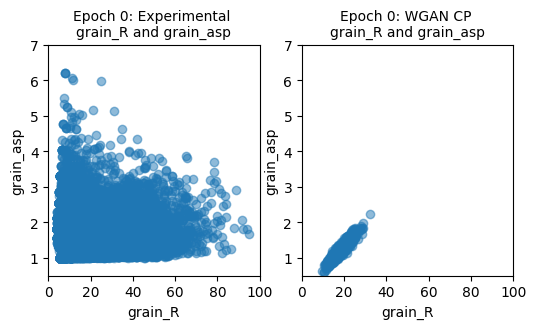

Epoch 1
Generator Loss: 0.0099
Discriminator Loss: d_loss_real = -0.0096, d_loss_fake = -0.0003
Wasserstein Distance: 0.0003
Number of generated grains lying inside experimental range: 0/20


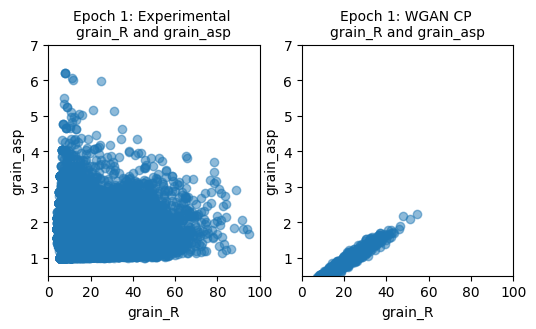

Epoch 2
Generator Loss: 0.0098
Discriminator Loss: d_loss_real = -0.0096, d_loss_fake = -0.0001
Wasserstein Distance: 0.0001
Number of generated grains lying inside experimental range: 0/20


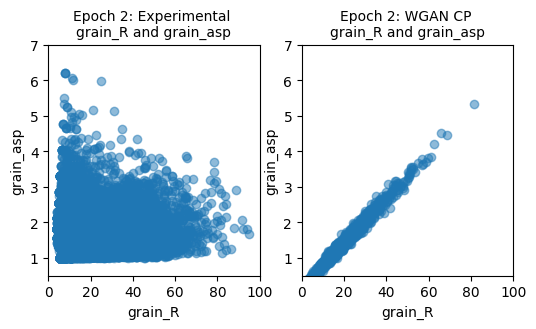

Epoch 3
Generator Loss: 0.0087
Discriminator Loss: d_loss_real = -0.0088, d_loss_fake = 0.0000
Wasserstein Distance: -0.0000
Number of generated grains lying inside experimental range: 0/20


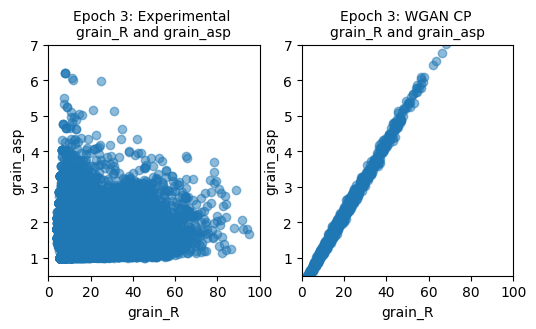

Epoch 4
Generator Loss: 0.0048
Discriminator Loss: d_loss_real = -0.0049, d_loss_fake = -0.0000
Wasserstein Distance: 0.0000
Number of generated grains lying inside experimental range: 0/20


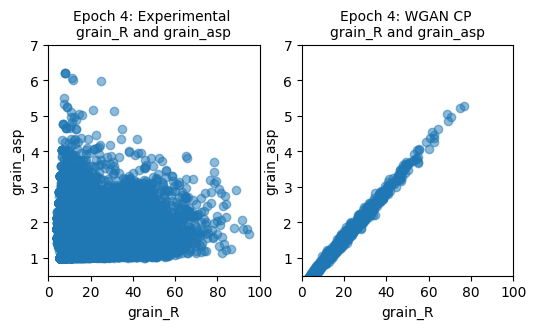

Epoch 5
Generator Loss: 0.0041
Discriminator Loss: d_loss_real = -0.0041, d_loss_fake = -0.0000
Wasserstein Distance: 0.0000
Number of generated grains lying inside experimental range: 0/20


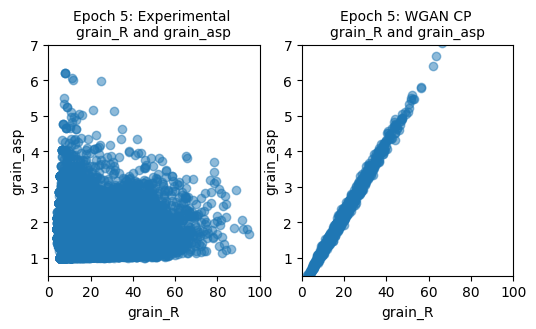

Epoch 6
Generator Loss: 0.0043
Discriminator Loss: d_loss_real = -0.0043, d_loss_fake = -0.0000
Wasserstein Distance: 0.0000
Number of generated grains lying inside experimental range: 0/20


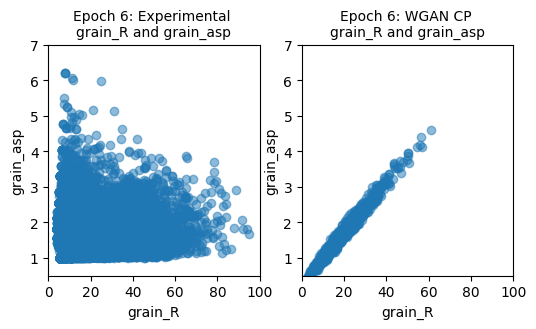

Epoch 7
Generator Loss: 0.0037
Discriminator Loss: d_loss_real = -0.0038, d_loss_fake = -0.0000
Wasserstein Distance: 0.0000
Number of generated grains lying inside experimental range: 0/20


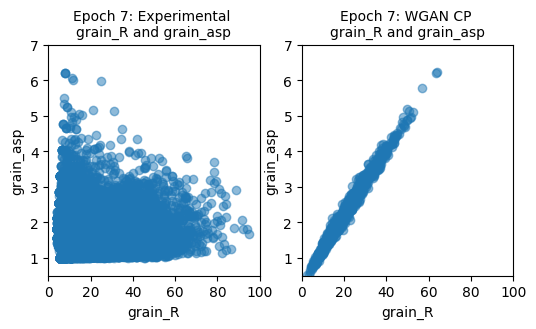

Epoch 8
Generator Loss: 0.0036
Discriminator Loss: d_loss_real = -0.0038, d_loss_fake = -0.0001
Wasserstein Distance: 0.0001
Number of generated grains lying inside experimental range: 0/20


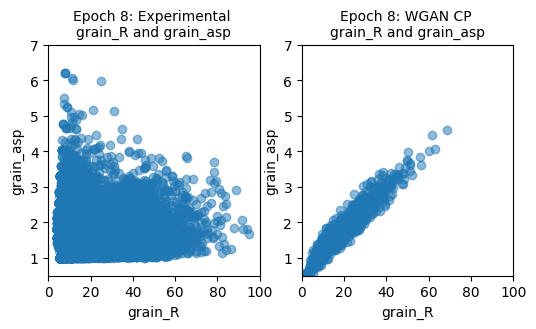

Epoch 9
Generator Loss: 0.0045
Discriminator Loss: d_loss_real = -0.0045, d_loss_fake = -0.0000
Wasserstein Distance: 0.0000
Number of generated grains lying inside experimental range: 0/20


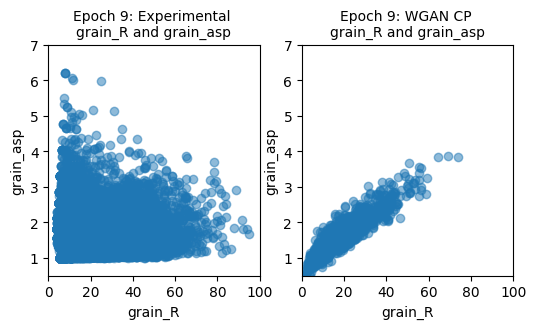

Epoch 10
Generator Loss: 0.0047
Discriminator Loss: d_loss_real = -0.0047, d_loss_fake = -0.0000
Wasserstein Distance: 0.0000
Number of generated grains lying inside experimental range: 0/20


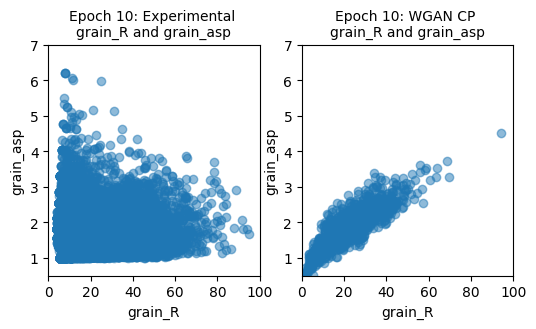

In [8]:
# initialize generator and discriminator net
generator_net = Generator(latent_Gaussian_dimension, number_of_grain_features).to(device)
discriminator_net = Discriminator(number_of_grain_features).to(device)

exp_max_R = np.max(grainsData[:,0])
exp_min_R = np.min(grainsData[:,0])
exp_max_asp = np.max(grainsData[:,1])
exp_min_asp = np.min(grainsData[:,1])

print("[min, max] of exp_grain_R: [{}, {}]".format(exp_min_R, exp_max_R))
print("[min, max] of exp_grain_asp: [{}, {}]".format(exp_min_asp, exp_max_asp))

# initialize generator and discriminator optimizer
generator_optimizer = optim.RMSprop(generator_net.parameters(), lr=learning_rate)
discriminator_optimizer = optim.RMSprop(discriminator_net.parameters(), lr=learning_rate)

# Create DataLoader
dataloader = DataLoader(grainsData, batch_size=batch_size, shuffle=True)

# There are four loops: epoch loop, batch loop, generator loop, critic loop

for epoch in range(0, num_epochs + 1):
    g_loss_list = []
    d_loss_real_list = []
    d_loss_fake_list = []
    Wasserstein_distance_list = []

    for batch_index, real_grains in enumerate(dataloader):
        batch_size_local = real_grains.shape[0]
        real_grains = real_grains.to(torch.float32)
        real_grains = real_grains.to(device)

        for gen_iter in range(num_generator_iterations):

            d_loss_real_iter = []
            d_loss_fake_iter = []
            Wasserstein_distance_iter = []

            for critic_iter in range(num_critic_iterations):
                generator_net.eval()
                discriminator_net.train()
                discriminator_optimizer.zero_grad()

                for param in discriminator_net.parameters():
                   param.data.clamp_(-weight_clipping_limit, weight_clipping_limit)

                d_loss_real = discriminator_net(real_grains)
                d_loss_real = d_loss_real.mean().view(1)

                # Train with fake grains
                noise = torch.randn(batch_size_local, latent_Gaussian_dimension, device=device, dtype=torch.float32)
                fake_grains = generator_net(noise)

                d_loss_fake = discriminator_net(fake_grains)
                d_loss_fake = d_loss_fake.mean().view(1)

                d_loss = d_loss_fake - d_loss_real 
                d_loss.backward()

                Wasserstein_distance = d_loss_real - d_loss_fake
                discriminator_optimizer.step()

                #d_loss_iter.append(d_loss.item())
                d_loss_real_iter.append(d_loss_real.item())
                d_loss_fake_iter.append(d_loss.item())
                Wasserstein_distance_iter.append(Wasserstein_distance.item())

            #d_loss_list.append(np.mean(d_loss_iter))
            d_loss_real_list.append(np.mean(d_loss_real_iter))
            d_loss_fake_list.append(np.mean(d_loss_fake_iter))
            Wasserstein_distance_list.append(np.mean(Wasserstein_distance_iter))
            # print(f'Discriminator iteration: {critic_iter}/{critic_iterations}, loss_fake: {d_loss_fake.data}, loss_real: {d_loss_real.data}')

            # Generator update
            generator_net.train()
            discriminator_net.eval()
            generator_optimizer.zero_grad()

            # Train generator
            noise = torch.randn(batch_size_local, latent_Gaussian_dimension, device=device, dtype=torch.float32)
            fake_grains = generator_net(noise)
            g_loss = discriminator_net(fake_grains)
            g_loss = - g_loss.mean().view(1)
            g_loss.backward()
            generator_optimizer.step()

            g_loss_list.append(g_loss.item())
            # print(f'Generator iteration: {gen_iter}/{generator_iterations}, g_loss: {g_loss.data}')

    ######################################
    # Print and saving training progress #
    ######################################

    if epoch % printAndSaveEvery_N_Epoch == 0:
        g_loss_value = np.mean(g_loss_list)
        d_loss_real_value = np.mean(d_loss_real_list)
        d_loss_fake_value = np.mean(d_loss_fake_list)
        Wasserstein_distance_value = np.mean(Wasserstein_distance_list)
        print("=====================================")
        print(f"Epoch {epoch}")
        print(f"Generator Loss: {g_loss_value:.4f}")
        print(f"Discriminator Loss: d_loss_real = {d_loss_real_value:.4f}, d_loss_fake = {d_loss_fake_value:.4f}")
        print(f"Wasserstein Distance: {Wasserstein_distance_value:.4f}")


    if epoch % printAndSaveEvery_N_Epoch == 0:
        with torch.no_grad():
            # Generate fake grains and save into csv file
            generate_times = 20
            # for each epoch, we wil generate 20 different groups of fake grains as generator is random
            outputPath = f"downsampled_grains_WGAN_CP/epoch_{epoch}"
            if os.path.exists(outputPath):
                # remove the directory if it exists and create new
                shutil.rmtree(outputPath)
                os.makedirs(outputPath)
            else:
                os.makedirs(outputPath)

            numberOfGeneratedGrainsLyingInsideExpRange = 0
            for i in range(generate_times):
                outputPathIndex = f"downsampled_grains_WGAN_CP/epoch_{epoch}"
                noise = torch.randn(number_of_reduced_grains, latent_Gaussian_dimension, device=device)

                fake_grains = generator_net(noise)
                fake_grains = fake_grains.cpu().numpy()
                # print(f"min, max grain_R: [{np.min(fake_grains[:, 0])}, {np.max(fake_grains[:, 0])}]")
                # print(f"min, max grain_asp: [{np.min(fake_grains[:, 1])}, {np.max(fake_grains[:, 1])}]")
                if np.min(fake_grains[:, 0]) >= exp_min_R and np.max(fake_grains[:, 0]) <= exp_max_R and np.min(fake_grains[:, 1]) >= exp_min_asp and np.max(fake_grains[:, 1]) <= exp_max_asp:
                    numberOfGeneratedGrainsLyingInsideExpRange += 1
                # print(fake_grains.shape)
                # Save as csv file, use pandas
                columns = ["grain_R", "grain_asp"]
                df = pd.DataFrame(fake_grains, columns=columns)
                df.to_csv(f"{outputPathIndex}/grains_{i+1}.csv", index=False)
            print(f"Number of generated grains lying inside experimental range: {numberOfGeneratedGrainsLyingInsideExpRange}/{generate_times}")
        plot_data(epoch, 1)
